### Lora vs Soft-prompting evaluation

Run ```train_finetuning.py``` to produce checkpoints to compare with this notebook.

Or download checkpoints from [google drive](https://drive.google.com/drive/folders/1cnyE_TMa3EPcfJy68xncmLGaqnZg0C91?usp=sharing) and
put them in the ```model``` folder (seen from the project root).

### Imports

In [294]:
%load_ext autoreload
%autoreload 2

from metrics import (
    SquaredError,
    FunctionClassError,
)

from models.baselines import ChebyshevKernelLinearRegression_LeastSquares

from metrics.utils import post_process

from interactive import load_checkpoint_with_config

from function_classes import (
    FunctionClass,
)

import matplotlib.pyplot as plt
import torch

from typing import NamedTuple, Any, Iterable
from pathlib import Path

from parse import process_config_from_file
from utils import get_latest_checkpoint_path_from_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Evaluation code

In [295]:
class ModelLoadSpecs(NamedTuple):
    name: str
    checkpoint_dir: Path

def evaluate_setup(base_model_specs: ModelLoadSpecs, finetuned_models_specs: list[ModelLoadSpecs]):

    model_load_specs = [base_model_specs] + finetuned_models_specs

    processed_config, parsed_config = process_config_from_file(filename=str(model_load_specs[-1].checkpoint_dir / "config.yml"),
                                                           include=None,
                                                           checkpoint_path=str(get_latest_checkpoint_path_from_dir(model_load_specs[0].checkpoint_dir)),
                                                           resume_training=False)

    base_fc: FunctionClass = processed_config['function_classes'][-1] # Choose the last function class from curriculum
    del processed_config # Make sure we don't use all memory on having a model in memory

    METRIC = SquaredError() #SquaredError()
    NUM_BATCHES = 1024
    #SEQ_LEN = base_fc.x_dist.batch_shape[1]
    X_DIM = parsed_config['x_dim']
    Y_DIM = parsed_config['y_dim']
    #X_SHAPE = torch.Size([B_SIZE, SEQ_LEN, X_DIM])
    #Y_SHAPE = torch.Size([B_SIZE, SEQ_LEN, Y_DIM])

    bench = FunctionClassError(METRIC, function_class=base_fc)

    MODELS = {
        load_specs.name: load_checkpoint_with_config(str(load_specs.checkpoint_dir / "config.yml"), 
                                                    str(get_latest_checkpoint_path_from_dir(load_specs.checkpoint_dir)), 
                                                    import_configs=False)
        for load_specs in model_load_specs
    }
    MODELS.update({
        "Poly. Regr.": ChebyshevKernelLinearRegression_LeastSquares(max_degree=5, x_dim=X_DIM, y_dim=Y_DIM),
        # RetrievalDictModel(x_dim=X_DIM, y_dim=Y_DIM),
        # ZeroModel(x_dim=X_DIM, y_dim=Y_DIM),
        # LeastSquaresModel(x_dim=X_DIM, y_dim=Y_DIM),
        # LassoModel(alpha=0.001, x_dim=X_DIM, y_dim=Y_DIM),
    })

    errs = bench.evaluate(MODELS.values(), num_batches=NUM_BATCHES)
    values = list(post_process(errs, confidence_level=[0.01]))

    return dict(zip(MODELS.keys(), values),)

### Plotting code

In [296]:
def plot_results(eval_data: dict[str, dict[str, torch.Tensor]], title: str = ""):

    for name, results in eval_data.items():

        plt.plot(results["accuracy"], label=f"{name}")
        plt.fill_between(range(len(results["accuracy"])), results["confidence_0.01_lower"][:, 0], results["confidence_0.01_upper"][:, 0], alpha=0.2)
        

    plt.ylabel(f"Squared Error")
    plt.xlabel(f"Context Length")
    plt.yscale("log")
    plt.ylim(1e-4, 5)
    plt.grid()
    
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='small')
    plt.title(title)
    plt.show()

### Paths

In [297]:
parent_checkpoint_dir = Path().resolve().parent / "models"
base_model_specs = ModelLoadSpecs(name='Base_Model', checkpoint_dir=parent_checkpoint_dir / "poly_base_model")

### 0 fixed coefficients, degree 5 polynomials

Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
LoraGPT2Model trainable parameters: 12288
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 512
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800


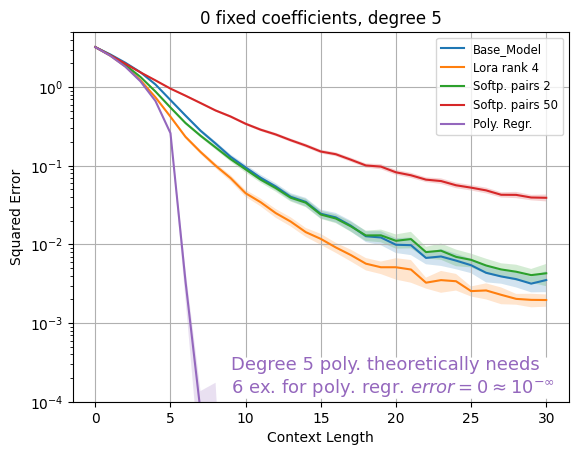

In [298]:
fine_tune_specs_0: list[ModelLoadSpecs] = [ModelLoadSpecs(name='Lora rank 4', checkpoint_dir=parent_checkpoint_dir / "poly_lora_4_model_fixed_0"),
                                         ModelLoadSpecs(name='Softp. pairs 2', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_2_model_fixed_0"),
                                         ModelLoadSpecs(name='Softp. pairs 50', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_50_model_fixed_0")]

eval_data = evaluate_setup(base_model_specs, fine_tune_specs_0)
plot_results(eval_data, title="0 fixed coefficients, degree 5")


### 1 fixed coefficients, degree 5 polynomials

Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
LoraGPT2Model trainable parameters: 12288
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 512
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800


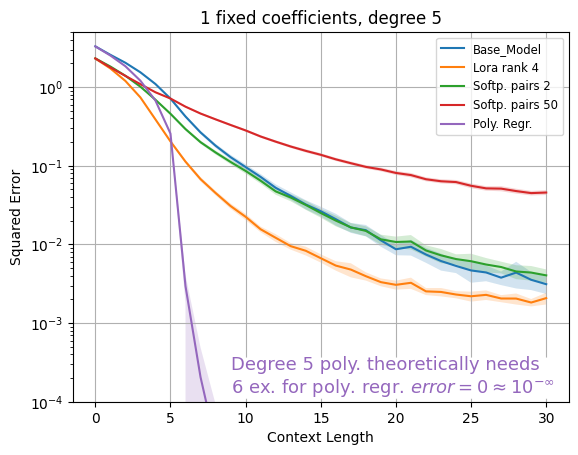

In [299]:
fine_tune_specs_1: list[ModelLoadSpecs] = [ModelLoadSpecs(name='Lora rank 4', checkpoint_dir=parent_checkpoint_dir / "poly_lora_4_model_fixed_1"),
                                         ModelLoadSpecs(name='Softp. pairs 2', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_2_model_fixed_1"),
                                         ModelLoadSpecs(name='Softp. pairs 50', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_50_model_fixed_1")]

eval_data = evaluate_setup(base_model_specs, fine_tune_specs_1)
plot_results(eval_data, title="1 fixed coefficients, degree 5")

### 3 fixed coefficients, degree 5 polynomials

Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
LoraGPT2Model trainable parameters: 12288
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 512
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800


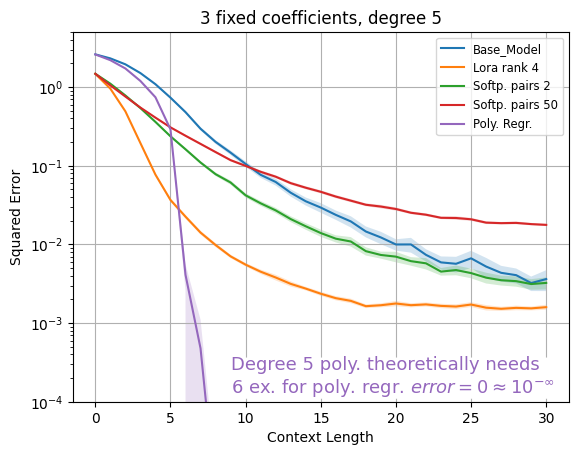

In [300]:
fine_tune_specs_3: list[ModelLoadSpecs] = [ModelLoadSpecs(name='Lora rank 4', checkpoint_dir=parent_checkpoint_dir / "poly_lora_4_model_fixed_3"),
                                         ModelLoadSpecs(name='Softp. pairs 2', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_2_model_fixed_3"),
                                         ModelLoadSpecs(name='Softp. pairs 50', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_50_model_fixed_3")]

eval_data = evaluate_setup(base_model_specs, fine_tune_specs_3)
plot_results(eval_data, title="3 fixed coefficients, degree 5")

### 5 fixed coefficients, degree 5 polynomials

Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
LoraGPT2Model trainable parameters: 12288
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 512
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800


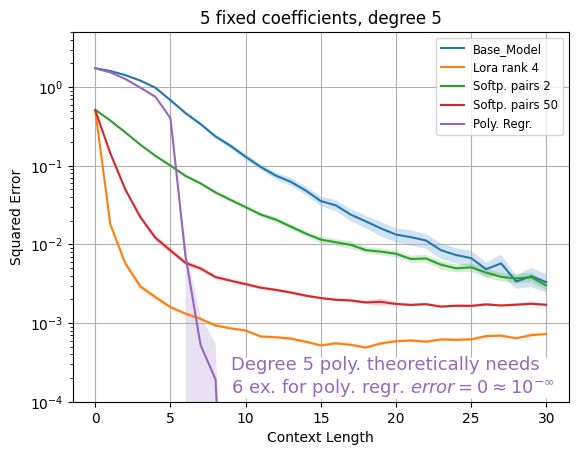

In [301]:
fine_tune_specs_5: list[ModelLoadSpecs] = [ModelLoadSpecs(name='Lora rank 4', checkpoint_dir=parent_checkpoint_dir / "poly_lora_4_model_fixed_5"),
                                         ModelLoadSpecs(name='Softp. pairs 2', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_2_model_fixed_5"),
                                         ModelLoadSpecs(name='Softp. pairs 50', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_50_model_fixed_5")]

eval_data = evaluate_setup(base_model_specs, fine_tune_specs_5)
plot_results(eval_data, title="5 fixed coefficients, degree 5")